# KPP test stand efficiency analysis 

In [1]:
# External libraries
import sys
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Mu2e pyutils
sys.path.append("../EventNtuple/utils/pyutils")

import pyprint 
import pyplot 

pr = pyprint.Print()
pl = pyplot.Plot()

# anapytools
from anapytools.read_data import DataReader
reader = DataReader()

# EffAna methods
sys.path.append("../Utils")
from processor import Processor # Process rec trees into ak
from clean import Clean # Filter data
from crvaging019 import CrvAging019 # Get PEs/layer for crvaging-019
from cuts import Cuts # Apply cuts
from trigger import Trigger # Trigger
from sort import Sort # Sort PEs / layer
from histogrammer import Histogrammer # Accumulate histograms 
from scan_inefficiency import ScanInefficiency # Scan inefficiency

## Process data

In [514]:
# Initialise
reader = DataReader()
processor = Processor(reader=reader)

# Configure dataset
defname = "rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.root"
run_number="002105" # "002101"

# Get filelist
filelist = processor.get_filelist(defname, run_number)

# Process files
arrays = processor.process_files_parallel(filelist)

# Print array info
arrays.type.show()
print("\n → FEBs:", len(arrays['PEsTemperatureCorrected'][0,:,0]))
print(" → Channels / FEB:", len(arrays['PEsTemperatureCorrected'][0,0,:]))

---> Loading Processor...
filelist: ['rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_000.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_002.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_003.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_004.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_005.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_006.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_007.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_008.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_009.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_010.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_011.root']

---> Starting parallel processing with 11 workers...
Processing 11 files in total

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-011-000.002105_000.root processed successfully!
  → Events in this file: 147635
  → Progress: 1/11 f

## Clean data 

In [515]:
pr.PrintNEvents(arrays)


---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
runNumber: 2105
subrunNumber: 0
spillIndex: 1
spillNumber: 1
eventNumber: 1
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 2.13, 51.4, ..., 0, 0, 0, 92.4, 72.3, 0, 0, 0, 0], ...]
trackSlope: [0.604, 0.821, 0.732, -0.401]
trackIntercept: [1.09e+03, 1.08e+03, 1.06e+03, 1.74e+03]
trackChi2: [0, 200, 312, 214]
trackPoints: [15, 10, 5, 4]
trackPEs: [1.35e+03, 863, 489, 726]
-------------------------------------------------------------------------------------



In [516]:
clean = Clean(arrays)
arrays = clean.remove_negative_PEs()
# Check structure 
arrays["PEsTemperatureCorrected"].type.show()

---> Loading Clean...
Removing 10021/1559545 events containing negative PE values
1549524 * 8 * 64 * float32


## Get PEs/layer

In [517]:
crvaging019 = CrvAging019(arrays)
arrays = crvaging019.crv_L_end()
arrays = crvaging019.crv_T(single_ended=True)
arrays = crvaging019.crv_DS()
print()
arrays.type.show()
pr.PrintNEvents(arrays, 1)

---> Loading CrvAging019...

---> Mapping CRV-L-end
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-T
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-DS
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

1549524 * {
    runNumber: int32,
    subrunNumber: int32,
    spillIndex: int32,
    spillNumber: int32,
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    trackSlope: 4 * float32,
    trackIntercept: 4 * float32,
    trackChi2: 4 * float32,
    trackPoints: 4 * int32,
    trackPEs: 4 * float32,
    PEs_per_layer_L_end: 4 * 32 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32
}

---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
runNumber: 2105
subrunNumber: 0
spillIndex: 1
spillNumber: 1
eventNumber: 1
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 2.13,

## Apply physics cuts

In [17]:

# # tot_PEs = ak.sum(
# #    ak.flatten(arrays['PEsTemperatureCorrected'], axis=-1),
# #    axis=-1
# # )

# def get_tot_PEs(arrays): 
    
#     # Sum over each module's layers
#     tot_PEs = (
#         ak.sum(ak.sum(arrays['PEs_per_layer_L_end'], axis=-1), axis=-1) +
#         ak.sum(ak.sum(arrays['PEs_per_layer_T'], axis=-1), axis=-1) +
#         ak.sum(ak.sum(arrays['PEs_per_layer_DS'], axis=-1), axis=-1)
#     )

#     return tot_PEs 
# tot_PEs = get_tot_PEs(arrays)
# tot_PEs.type.show()


---> Loading Cuts...
Initial number of events: 467738

---> Wrote:
	../Images/EffAna/h1_fid_cut.png


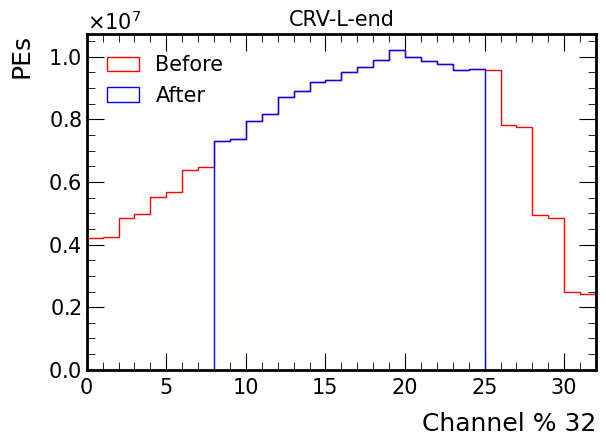


Fiducial cut (channels 8-24):
467738 * {
    runNumber: int32,
    subrunNumber: int32,
    spillIndex: int32,
    spillNumber: int32,
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    trackSlope: 4 * float32,
    trackIntercept: 4 * float32,
    trackChi2: 4 * float32,
    trackPoints: 4 * int32,
    trackPEs: 4 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32,
    PEs_per_layer_L_end: var * var * ?float32
}


In [283]:
# cuts = Cuts(arrays, verbose=True)

# min_PEs = 900
# max_PEs = 2250
# # 0,1,2,3 4,5,6,7 8,9,10,11 12,13,14,15 16,17,18,19 20,21,22,23 24,25,26,27, 28,29,30,31
# lo_chan=8
# hi_chan=24
# min_counter_hits=8*2
# max_counter_hits=100

# # Make a copy
# arrays_cut = ak.copy(arrays)

# # arrays_cut = cuts.tot_PE_cut(min_PEs=min_PEs, max_PEs=max_PEs, fout="../Images/EffAna/h1_tot_PEs_cut.png") 
# arrays_cut = cuts.fiducial_cut(lo_chan=lo_chan, hi_chan=hi_chan, fout="../Images/EffAna/h1_fid_cut.png") 
# # arrays_cut = cuts.counters_hit_cut(min_counter_hits=min_counter_hits, max_counter_hits=max_counter_hits)
# arrays_cut.type.show()

In [585]:
# Track cuts 

arrays_cut = ak.copy(arrays)

# Index 0 refers to the fit through the top layer of modules and center layer of modules (CRV-L and CRV-T).
# Index 1 refers to the fit through the center layer of modules (CRV-T).
# Index 2 refers to the fit through the top layer of modules (CRV-L).
# Index 3 refers to the fit through the bottom layer of modules (CRV-DS).

# arrays_cut["trackNDF"] = arrays_cut["trackPoints"] - 2 
# arrays_cut["trackChi2NDF"] = arrays_cut["trackChi2"]/arrays_cut["trackNDF"] #if arrays_cut["trackNDF"] > 0 else 0

# From Yuri
arrays_cut["trackChi2NDF"] = ak.where(arrays_cut['trackPoints'] > 2, arrays_cut['trackChi2'] / (arrays_cut['trackPoints'] - 2), -999)

# pr.PrintNEvents(arrays_cut)
arrays_cut.type.show()

# Cut on intercept, proxy for a fiducial cut
trackIntercept_L_lo = 1100
trackIntercept_L_hi = 1500 # 600

trackIntercept_DS_lo = 1500
trackIntercept_DS_hi = 2000 # 600

trackIntercept_condition = ( 
    (arrays_cut.trackIntercept[:,2] >= trackIntercept_L_lo) &
    (arrays_cut.trackIntercept[:,2] <= trackIntercept_L_hi) #  &
    # (arrays_cut.trackIntercept[:,3] >= trackIntercept_DS_lo) & 
    # (arrays_cut.trackIntercept[:,3] <= trackIntercept_DS_hi)
)

# Cut on chi2 in CRV-L-end & CRV-T
trackChi2NDF_lo = 0
trackChi2NDF_hi = 30

trackChi2NDF_condition = ak.all(
    ((arrays_cut.trackChi2NDF[:, 2:4] > trackChi2NDF_lo) 
    & (arrays_cut.trackChi2NDF[:, 2:4] <= trackChi2NDF_hi)),
    axis=1
)

# trackChi2NDF_condition = (
#     (arrays_cut.trackChi2NDF[:, 0] > trackChi2NDF_lo) 
#     & (arrays_cut.trackChi2NDF[:, 0] <= trackChi2NDF_hi)
# )

trackPEs_lo = 0 
trackPEs_hi = 750

trackPEs_condition = ak.all(
    (arrays_cut.trackPEs[:, 2:4] >= trackPEs_lo) &
    (arrays_cut.trackPEs[:, 2:4] <= trackPEs_hi),
    axis=1
)

# trackPEs_condition = (arrays_cut.trackPEs[:, 0] <= trackPEs_hi)

trackPoints_hi = 8
trackPoints_lo = 1000 # is this allowed

trackPoints_condition = ak.all(
    (arrays_cut.trackPoints[:, 2:4] <= trackPoints_hi) &
    (arrays_cut.trackPoints[:, 2:4] >= trackPoints_lo),
    axis=1
)

# slope=dx/dy
# So a vertical track should have a slope of 0

trackSlope_lo = -2
trackSlope_hi = 2

trackSlope_condition = ak.all(
    (arrays_cut.trackSlope[:, 2:4] >= trackSlope_lo)
    & (arrays_cut.trackSlope[:, 2:4] <= trackSlope_hi),
    axis=1
)

# trackSlope_condition = (
#     (arrays_cut.trackSlope[:, 0] >= trackSlope_lo)
#     & (arrays_cut.trackSlope[:, 0] <= trackSlope_hi)
# )

arrays_cut = arrays_cut[ 
    trackIntercept_condition &
    trackChi2NDF_condition &
    trackPEs_condition # &
    # trackPoints_condition  # &
    # trackSlope_condition
]   

n_before = len(arrays)
n_after = len(arrays_cut)
n_removed = n_before - n_after

print(f"Events removed: {n_removed} ({100*n_removed/n_before:.1f}%)")
print(f"Events remaining: {n_after} ({100*n_after/n_before:.1f}% of initial)")

1549524 * {
    runNumber: int32,
    subrunNumber: int32,
    spillIndex: int32,
    spillNumber: int32,
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    trackSlope: 4 * float32,
    trackIntercept: 4 * float32,
    trackChi2: 4 * float32,
    trackPoints: 4 * int32,
    trackPEs: 4 * float32,
    PEs_per_layer_L_end: 4 * 32 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32,
    trackChi2NDF: 4 * float64
}
Events removed: 1460639 (94.3%)
Events remaining: 88885 (5.7% of initial)


## Trigger

In [586]:
# Initiliase
trigger = Trigger(arrays_cut)
# Find triggers
arrays_cut = trigger.get_triggers()
# Apply triggers
arrays_cut = trigger.apply_triggers()

---> Loading Trigger...
---> Triggering
-> 86964/88885 = 97.84% events have triggers


## Sort PEs in test module

In [587]:
sort = Sort()
arrays_cut["PEs_per_layer_T_sorted"] = sort.sort_layer_PEs(arrays_cut['PEs_per_layer_T'])
sort.print_sorted_layer_PEs(arrays_cut['PEs_per_layer_T_sorted'])

---> Loading Sort...
Sorted PEs:
0 [104, 110, 114, 170]
1 [76.2, 79.6, 82.2, 94.1]
2 [74.8, 78.2, 121, 212]
3 [91.2, 105, 117, 117]
4 [78.4, 88.7, 92.1, 135]
5 [77.5, 84.8, 117, 200]
6 [90.5, 114, 127, 146]
7 [60.3, 80.9, 90.2, 94.2]
8 [70.8, 95.5, 104, 111]
9 [99, 121, 138, 217]
...


x_max = 1311.577392578125
---> Loading Hists...

---> Wrote:
	 ../Images/EffAna/h1_sorted_PEs.png


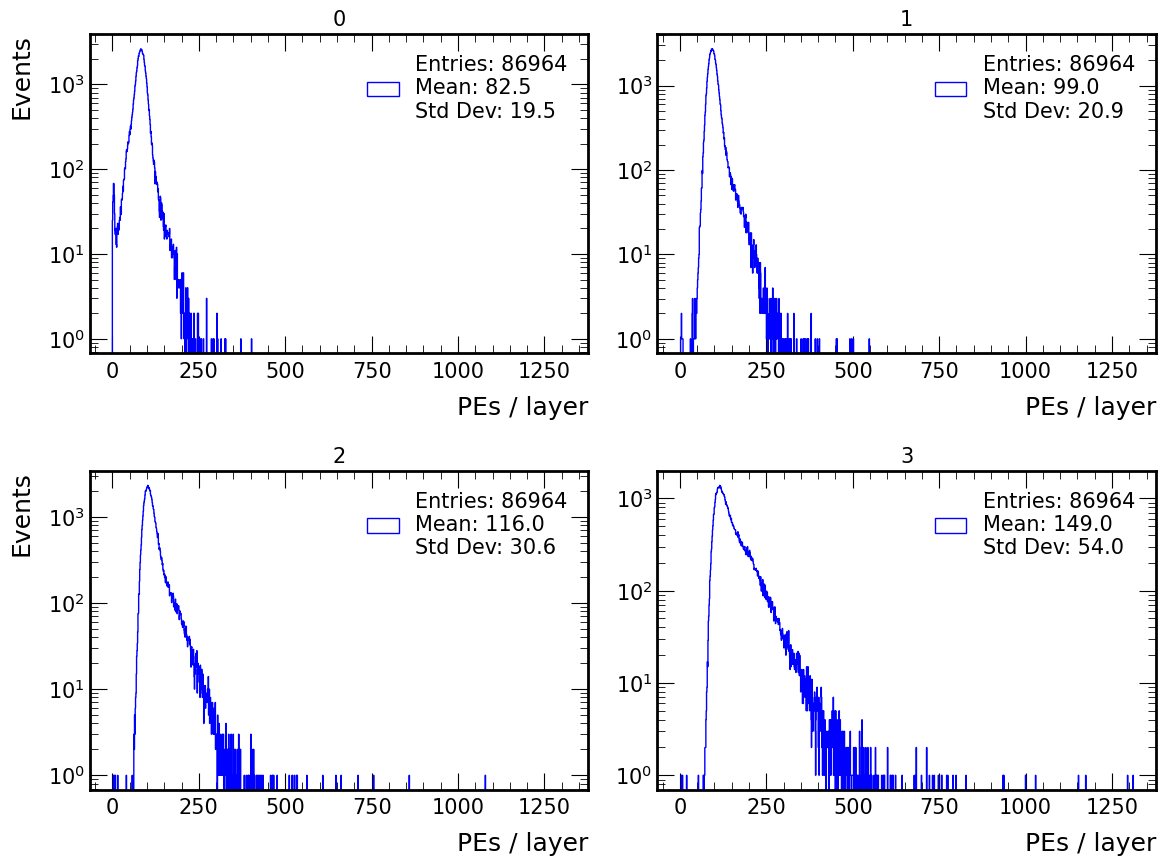

In [588]:
x_max = max(ak.flatten(arrays_cut['PEs_per_layer_T_sorted'][:,3], axis=None))
print(f"x_max = {x_max}")
histogrammer = Histogrammer(nbins=int(x_max), x_range=(0, x_max)) 
hists = histogrammer.acc_hists(arrays_cut)
histogrammer.plot_hists(hists, fout="../Images/EffAna/h1_sorted_PEs.png")

## Scan inefficiency 

---> Loading Inefficiency...
PE thresholds to scan:
[ 10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.
  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135. 140. 145.
 150.]

---> Wrote:
	 ../Images/EffAna/gr_eff_arr.png


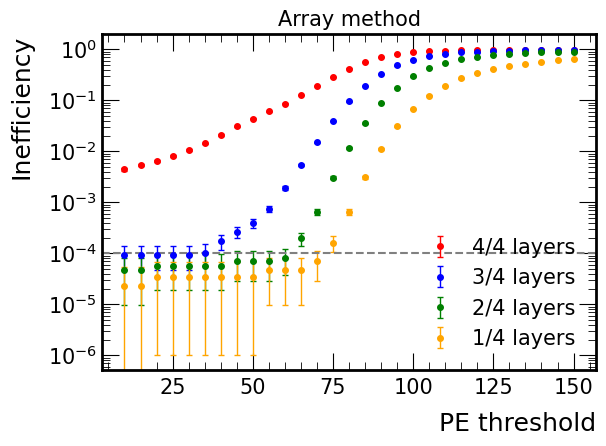


---> Wrote:
	 ../Images/EffAna/gr_eff_hist.png


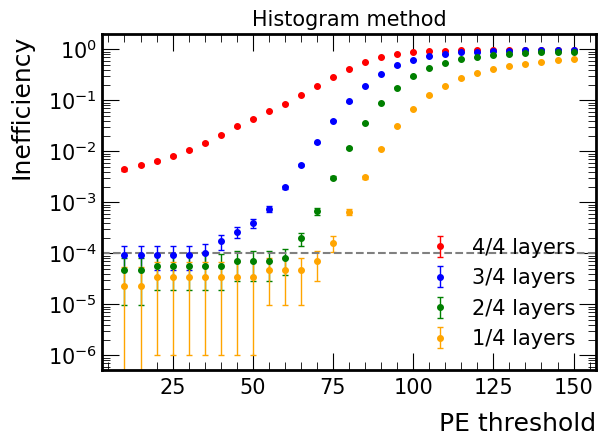

In [589]:
inefficiency = ScanInefficiency()

# Array method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_arrays(arrays_cut)
inefficiency.plot_scan(ineff, ineff_err, title="Array method", fout="../Images/EffAna/gr_eff_arr.png")

# print("threshold, ineff")
# for i_thres, threshold in enumerate(thresholds):
#     print(f"{threshold}, {ineff[1][i_thres]}") 

# Histogram method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_hists(hists)
inefficiency.plot_scan(ineff, ineff_err, title="Histogram method", fout="../Images/EffAna/gr_eff_hist.png")

# print("threshold, ineff")
# for i_thres, threshold in enumerate(thresholds):
#     print(f"{threshold}, {ineff[1][i_thres]}") 
    

## Further analysis

In [590]:
# What's happening below 50 PEs? Use 3/4 layers
arrays_fail_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==True]
arrays_pass_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==False]

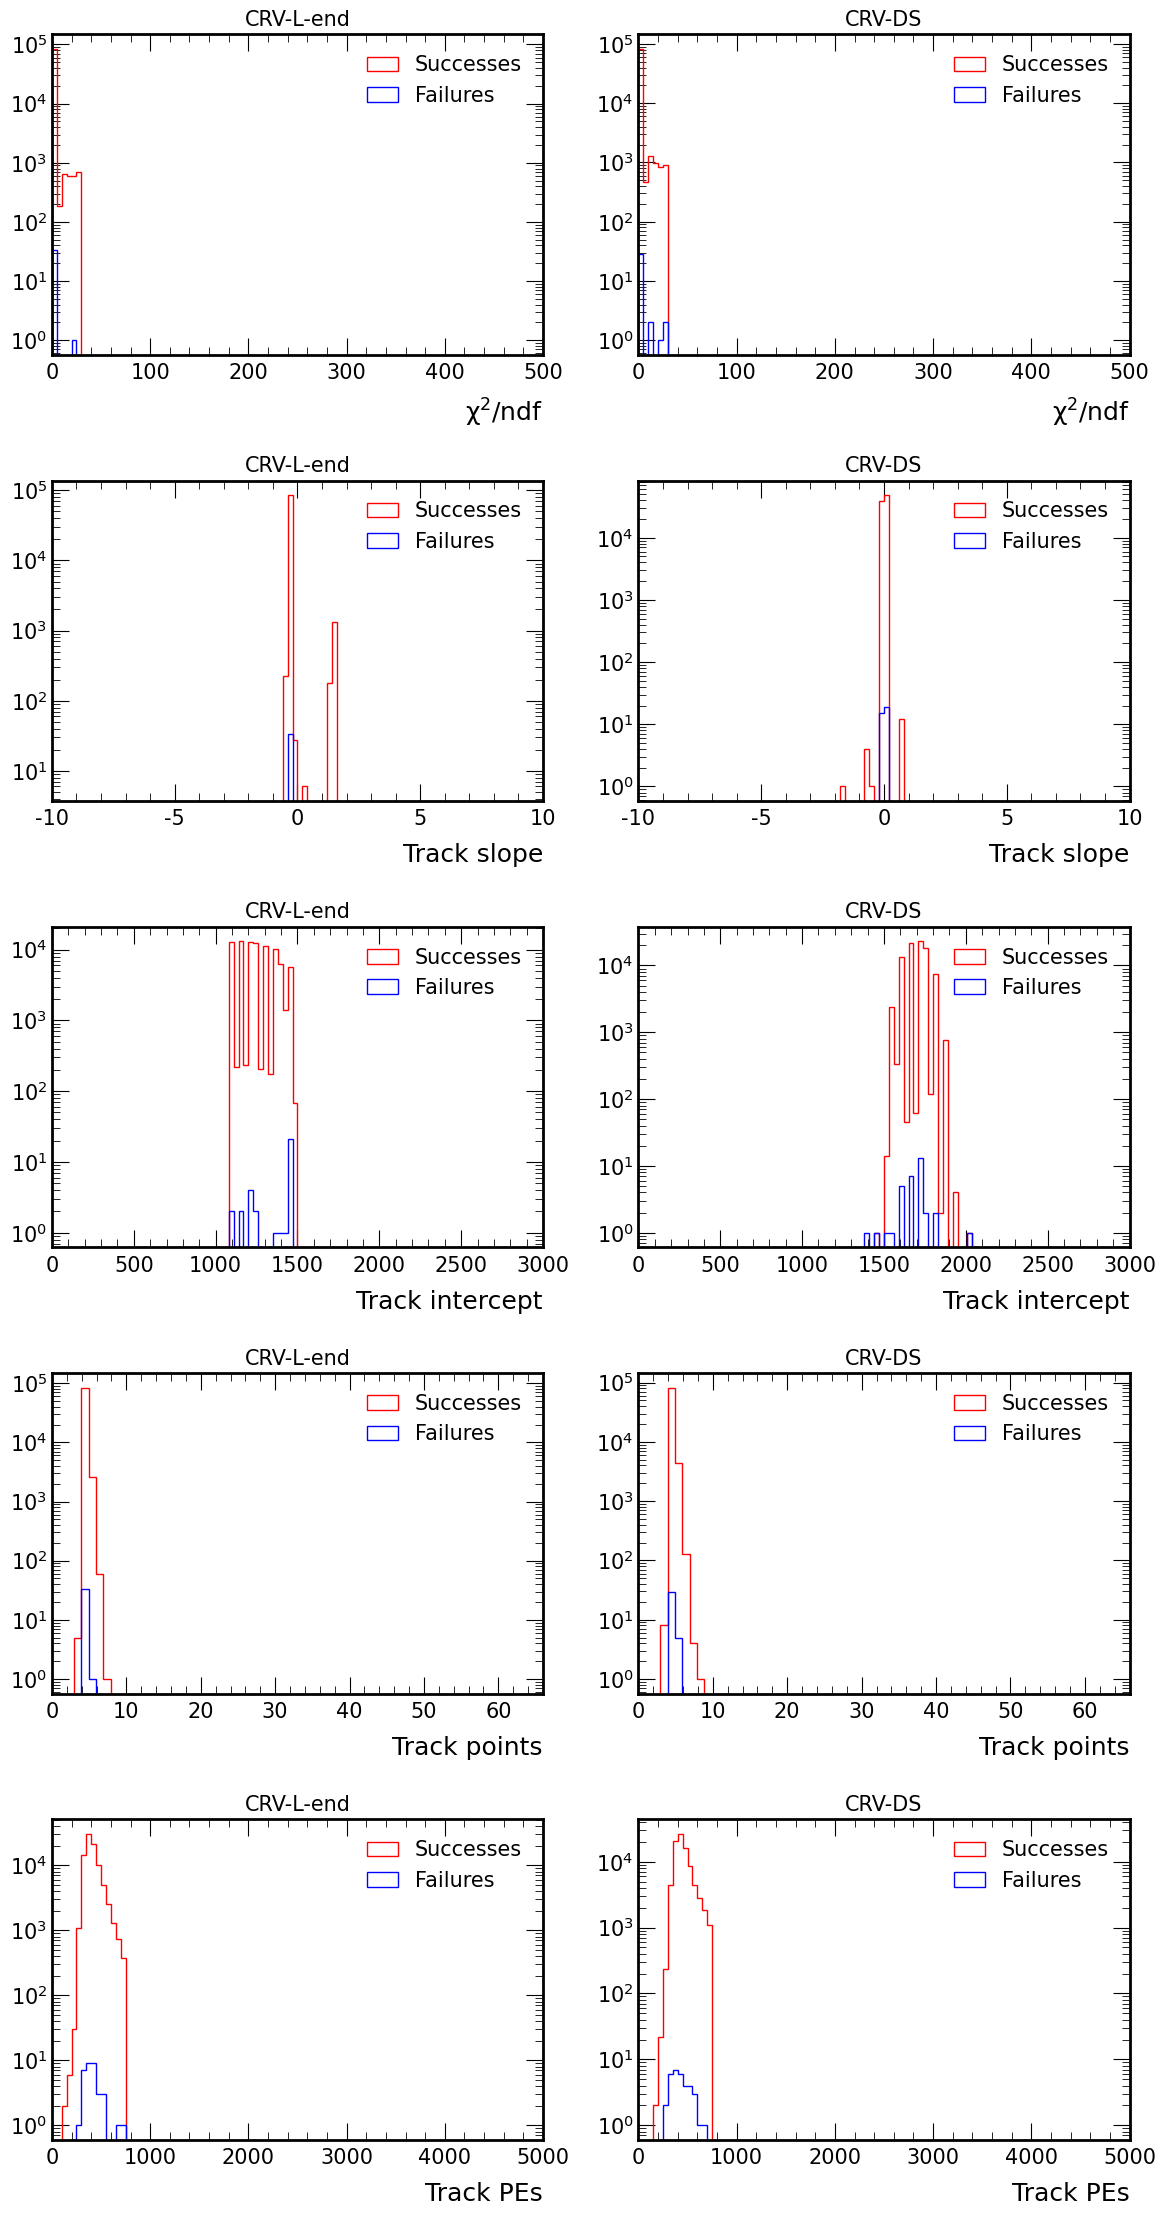

In [591]:
# Plot track parameters 

# ndex 0 refers to the fit through the top layer of modules and center layer of modules (CRV-L and CRV-T).
# Index 1 refers to the fit through the center layer of modules (CRV-T).
# Index 2 refers to the fit through the top layer of modules (CRV-L).
# Index 3 refers to the fit through the bottom layer of modules (CRV-DS).

fig, ax = plt.subplots(5, 2, figsize=(1.5*8, 3.75*6))

pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackChi2NDF"][:,2], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackChi2NDF"][:,2], axis=None)
    },
    nbins=100, xmin=0, xmax=500,
    xlabel=fr"$\chi^{2}/ndf$", title="CRV-L-end",
    log_y=True, ax=ax[0,0]
) 

pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackChi2NDF"][:,3], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackChi2NDF"][:,3], axis=None)
    },
    nbins=100, xmin=0, xmax=500,
    xlabel=fr"$\chi^{2}/ndf$", title="CRV-DS",
    log_y=True, ax=ax[0,1]
) 

pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackSlope"][:,2], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackSlope"][:,2], axis=None)
    },
    nbins=100, xmin=-10, xmax=10,
    xlabel="Track slope", title="CRV-L-end",
    log_y=True, ax=ax[1,0]
) 

pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackSlope"][:,3], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackSlope"][:,3], axis=None)
    },
    nbins=100, xmin=-10, xmax=10,
    xlabel="Track slope", title="CRV-DS",
    log_y=True, ax=ax[1,1]
) 

pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackIntercept"][:,2], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackIntercept"][:,2], axis=None)
    },
    nbins=100, xmin=0, xmax=3000,
    xlabel="Track intercept", title="CRV-L-end",
    log_y=True, ax=ax[2,0]
) 

pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackIntercept"][:,3], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackIntercept"][:,3], axis=None)
    },
    nbins=100, xmin=0, xmax=3000,
    xlabel="Track intercept", title="CRV-DS",
    log_y=True, ax=ax[2,1]
) 


pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackPoints"][:,2], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackPoints"][:,2], axis=None)
    },
    nbins=67, xmin=0, xmax=66,
    xlabel="Track points", title="CRV-L-end",
    log_y=True, ax=ax[3,0]
) 

pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackPoints"][:,3], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackPoints"][:,3], axis=None)
    },
    nbins=67, xmin=0, xmax=66,
    xlabel="Track points", title="CRV-DS",
    log_y=True, ax=ax[3,1]
) 

pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackPEs"][:,2], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackPEs"][:,2], axis=None)
    },
    nbins=100, xmin=0, xmax=5000,
    xlabel="Track PEs", title="CRV-L-end",
    log_y=True, ax=ax[4,0]
) 

pl.Plot1DOverlay(
    {
        "Successes" : ak.flatten(arrays_pass_50["trackPEs"][:,3], axis=None),
        "Failures" : ak.flatten(arrays_fail_50["trackPEs"][:,3], axis=None)
    },
    nbins=100, xmin=0, xmax=5000,
    xlabel="Track PEs", title="CRV-DS",
    log_y=True,  ax=ax[4,1]
) 

plt.tight_layout()
# plt.savefig("../Images/EffAna/h1_track_params_pass_fail_no_cuts.png", dpi=300)
plt.show()

In [571]:
# # Plot track parameters 

# # ndex 0 refers to the fit through the top layer of modules and center layer of modules (CRV-L and CRV-T).
# # Index 1 refers to the fit through the center layer of modules (CRV-T).
# # Index 2 refers to the fit through the top layer of modules (CRV-L).
# # Index 3 refers to the fit through the bottom layer of modules (CRV-DS).

# fig, ax = plt.subplots(3, 2, figsize=(1.5*8, 2.5*6))

# pl.Plot1DOverlay(
#     {
#         "Successes" : ak.flatten(arrays_pass_50["trackChi2NDF"][:,0], axis=None),
#         "Failures" : ak.flatten(arrays_fail_50["trackChi2NDF"][:,0], axis=None)
#     },
#     nbins=100, xmin=0, xmax=10,
#     xlabel=fr"$\chi^{2}/ndf$", title="CRV-L-end & CRV-T",
#     log_y=True, ax=ax[0,0]
# ) 

# pl.Plot1DOverlay(
#     {
#         "Successes" : ak.flatten(arrays_pass_50["trackSlope"][:,0], axis=None),
#         "Failures" : ak.flatten(arrays_fail_50["trackSlope"][:,0], axis=None)
#     },
#     nbins=200, xmin=-10, xmax=10,
#     xlabel="Track slope", title="CRV-L-end & CRV-T",
#     log_y=True, ax=ax[0,1]
# ) 

# pl.Plot1DOverlay(
#     {
#         "Successes" : ak.flatten(arrays_pass_50["trackIntercept"][:,0], axis=None),
#         "Failures" : ak.flatten(arrays_fail_50["trackIntercept"][:,0], axis=None)
#     },
#     nbins=100, xmin=0, xmax=3000,
#     xlabel="Track intercept", title="CRV-L-end & CRV-T",
#     log_y=True, ax=ax[1,0]
# ) 


# pl.Plot1DOverlay(
#     {
#         "Successes" : ak.flatten(arrays_pass_50["trackPoints"][:,0], axis=None),
#         "Failures" : ak.flatten(arrays_fail_50["trackPoints"][:,0], axis=None)
#     },
#     nbins=67, xmin=0, xmax=66,
#     xlabel="Track points", title="CRV-L-end & CRV-T",
#     log_y=True, ax=ax[1,1]
# ) 

# pl.Plot1DOverlay(
#     {
#         "Successes" : ak.flatten(arrays_pass_50["trackPEs"][:,0], axis=None),
#         "Failures" : ak.flatten(arrays_fail_50["trackPEs"][:,0], axis=None)
#     },
#     nbins=100, xmin=0, xmax=5000,
#     xlabel="Track PEs", title="CRV-L-end & CRV-T",
#     log_y=True, ax=ax[2,0]
# ) 


# plt.tight_layout()
# plt.savefig("../Images/EffAna/h1_track_params_2_pass_fail_no_cuts.png", dpi=300)
# plt.show()

In [180]:
def event_display(arrays, runNumber, subrunNumber, eventNumber, spillNumber, spillIndex, fout=None): 
    # Get event
    this_event = arrays[ 
        (arrays["runNumber"]==runNumber) & 
        (arrays["subrunNumber"]==subrunNumber) &
        (arrays["eventNumber"]==eventNumber) &
        (arrays["spillNumber"]==spillNumber) &
        (arrays["spillIndex"]==spillIndex) 
    ]

    # pr.PrintNEvents(this_event)

    # Get rows
    rows = np.array([
        this_event["PEs_per_layer_L_end"][0][3],  # each row is 20 mm high
        this_event["PEs_per_layer_L_end"][0][2], 
        this_event["PEs_per_layer_L_end"][0][1],
        this_event["PEs_per_layer_L_end"][0][0],
        this_event["PEs_per_layer_T"][0][3],
        this_event["PEs_per_layer_T"][0][2],
        this_event["PEs_per_layer_T"][0][1],
        this_event["PEs_per_layer_T"][0][0],
        this_event["PEs_per_layer_DS"][0][3],
        this_event["PEs_per_layer_DS"][0][2],
        this_event["PEs_per_layer_DS"][0][1],
        this_event["PEs_per_layer_DS"][0][0]
    ])

    fig, ax = plt.subplots(figsize=(12,8))

    # Merge adjacent counters 
    merged_rows = []
    for row in rows:
        pairs = row.reshape(-1, 2)
        merged_row = np.sum(pairs, axis=1)
        merged_rows.append(merged_row)
    merged_rows = np.array(merged_rows)
    
    # Calculate positions
    n_channels = merged_rows.shape[1]
    x_edges = np.linspace(n_channels, 0, n_channels+1)
    y_positions = np.arange(13)  # 0 to 8 for edges of 8 layers
    
    # Create heatmap
    im = ax.pcolormesh(x_edges, y_positions, merged_rows, 
                       cmap="coolwarm", vmax=None)
    ax.invert_yaxis()
    ax.invert_xaxis()
    
    # For ticks and grid, use the centers of the bins
    y_ticks = np.arange(12)  # 0 to 7 for centers of 8 layers
    ax.set_yticks(y_ticks + 0.5)  # Center the ticks in the bins
    ax.set_yticklabels(y_ticks)  # Show original layer numbers

    # Add text annotations for non-zero values
    for i in range(merged_rows.shape[0]):
        for j in range(merged_rows.shape[1]):
            value = merged_rows[i, j]
            if value > 0:
                x_pos = (x_edges[j] + x_edges[j+1]) / 2
                y_pos = y_positions[i] + 0.5  # Center in the bin
                ax.text(x_pos, y_pos, f'{value:.1f}', 
                       ha='center', va='center', 
                       color='white',
                       fontsize=13)

    # Add dividing line between modules
    ax.axhline(8, c="red", linestyle="--")
    ax.axhline(4, c="red", linestyle="--")
    
    # Colorbar and labels
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('PEs')
    
    ax.set_title(f"run {runNumber}, subrun {subrunNumber}, event {eventNumber}, spill {spillNumber}, spill idx {spillIndex}")
    ax.set_xlabel("Channel % 16")
    ax.set_ylabel("Layer")

    # Grid
    ax.set_xticks(x_edges)
    ax.set_yticks(y_positions)
    ax.grid(True, linestyle='--', alpha=0.75)
    
    plt.tight_layout()

    if fout: 
        plt.savefig(fout, dpi=300)
        
    plt.show()
    plt.close()

    return pd.DataFrame(merged_rows)

In [181]:
pr.PrintNEvents(arrays_cut)
print(arrays_cut.fields)


---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
runNumber: 2101
subrunNumber: 1
spillIndex: 1
spillNumber: 283
eventNumber: 2
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0.919, 0, 0, 0, 0, 0, 0], ...]
trackSlope: [0.295, 0.318, 0.365, 0.561]
trackIntercept: [1.04e+03, 1.04e+03, 1.02e+03, 1.57e+03]
trackChi2: [0, 150, 275, 268]
trackPoints: [13, 8, 5, 5]
trackPEs: [1.78e+03, 1.24e+03, 542, 460]
PEs_per_layer_L_end: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.942, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_T: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 167, 141, 0, 0, 1.04, 0, 0, 0, 0, 0], ...]
PEs_per_layer_DS: [[0, 0, 0, 1.07, 0, 1.06, 0, 0, 7.52, 18, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
trackNDF: [11, 6, 3, 3]
trackChi2NDF: [0, 25, 91.7, 89.2]
trig_L_end_layers: [1, 1, 1, 1]
trig_DS_layers: [1, 1, 1, 1]
trig_L_end: True
trig_DS: True
trig: True
PEs_per_layer_T_sorted: [91.4, 109, 115, 311]
fa

['runNumber', 'subrunNumber', 'spillIndex', 'spillNumber', 'eventNumber', 'PEsTemperatureCorrected', 'trackSlope', 'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 'PEs_per_layer_L_end', 'PEs_per_layer_T', 'PEs_per_layer_DS', 'trackNDF', 'trackChi2NDF', 'trig_L_end_layers', 'trig_DS_layers', 'trig_L_end', 'trig_DS', 'trig', 'PEs_per_layer_T_sorted', 'fail_10.0', 'fail_15.0', 'fail_20.0', 'fail_25.0', 'fail_30.0', 'fail_35.0', 'fail_40.0', 'fail_45.0', 'fail_50.0', 'fail_55.0', 'fail_60.0', 'fail_65.0', 'fail_70.0', 'fail_75.0', 'fail_80.0', 'fail_85.0', 'fail_90.0', 'fail_95.0', 'fail_100.0', 'fail_105.0', 'fail_110.0', 'fail_115.0', 'fail_120.0', 'fail_125.0', 'fail_130.0', 'fail_135.0', 'fail_140.0', 'fail_145.0', 'fail_150.0']


,runNumber,subrunNumber,eventNumber,spillNumber,spillIndex
0,2101,1,569,285,3
1,2101,1,597,307,25
2,2101,1,208,311,29
3,2101,1,481,325,43
4,2101,1,261,340,58
...,...,...,...,...,...
75,2101,3,287,1098,252
76,2101,3,515,1103,257
77,2101,3,285,1106,260
78,2101,3,540,1119,273


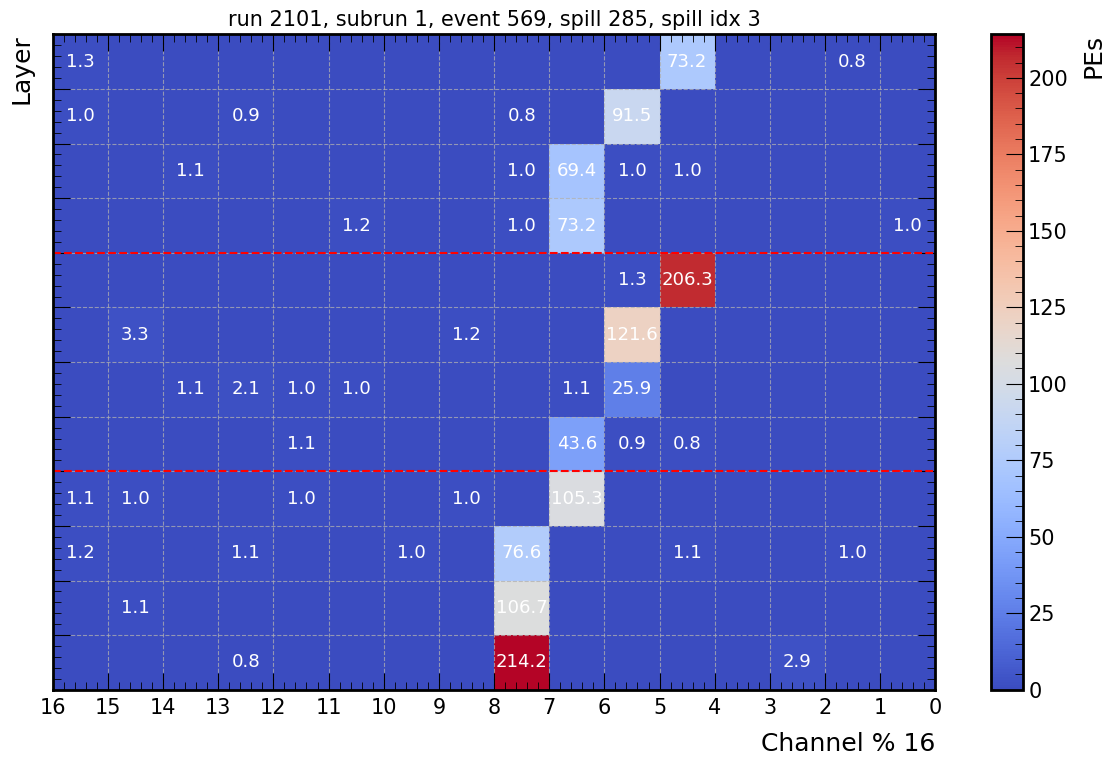

In [182]:
# What's happening below 50 PEs? Use 3/4 layers
arrays_fail_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==True]
arrays_pass_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==False]

print(arrays_fail_50.fields)
df_arrays_fail_50 = pd.DataFrame({
    "runNumber": ak.flatten(arrays_fail_50.runNumber, axis=None),
    "subrunNumber": ak.flatten(arrays_fail_50.subrunNumber, axis=None),
    "eventNumber": ak.flatten(arrays_fail_50.eventNumber, axis=None),
    "spillNumber": ak.flatten(arrays_fail_50.spillNumber, axis=None),
    "spillIndex": ak.flatten(arrays_fail_50.spillIndex, axis=None)
})

display(df_arrays_fail_50)

df_arrays_fail_50.to_csv(f"arrays_fail_50.csv")

# Automatically get values from the first row (index 0)
index = 0
runNumber = df_arrays_fail_50.iloc[index]['runNumber']
subrunNumber = df_arrays_fail_50.iloc[index]['subrunNumber']
eventNumber = df_arrays_fail_50.iloc[index]['eventNumber']
spillNumber = df_arrays_fail_50.iloc[index]['spillNumber']
spillIndex = df_arrays_fail_50.iloc[index]['spillIndex']

rows = event_display(arrays,
                     runNumber=runNumber,
                     subrunNumber=subrunNumber,
                     eventNumber=eventNumber,
                     spillNumber=spillNumber,
                     spillIndex=spillIndex,
                     fout=f"../Images/EventDisplays/ed_{runNumber}_{subrunNumber}_{eventNumber}_{spillNumber}_{spillIndex}_.png")

    # Get event
this_event = arrays_cut[ 
    (arrays_cut["runNumber"]==runNumber) & 
    (arrays_cut["subrunNumber"]==subrunNumber) &
    (arrays_cut["eventNumber"]==eventNumber) &
    (arrays_cut["spillNumber"]==spillNumber) &
    (arrays_cut["spillIndex"]==spillIndex) 
]

# pr.PrintNEvents(this_event)
# # this_event = arrays_cut[(arrays_cut["eventNumber"]==eventNumber) & (arrays_cut["subrun"]==subrun)]

# # print(len(this_event))
# # pr.PrintNEvents(this_event, 21)
# rows = event_display(arrays, eventNumber=eventNumber, subrun=subrun, fout=f"../Images/EventDisplays/ed_f{subrun}_{eventNumber}.png")
# rows.to_csv(f"no_cuts_{subrun}_{eventNumber}.csv")
# rows = event_display(arrays_cut, eventNumber=eventNumber, subrun=subrun, fout=f"../Images/EventDisplays/ed_f{subrun}_{eventNumber}.png")
# # rows = event_display(arrays_50, eventNumber=eventNumber, subrun=subrun, fout=f"../Images/EventDisplays/ed_f{subrun}_{eventNumber}.png")
# rows.to_csv(f"cuts_{subrun}_{eventNumber}.csv")

# display(rows)

In [26]:
# pr.PrintNEvents(arrays_pass_50)
# pr.PrintNEvents(arrays_fail_50)
# print(arrays_fail_50)

In [25]:
# Plot noise in counters 

# How many counters have PEs under 10? 

# pass_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==False]["PEsTemperatureCorrected"]
# fail_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==True]["PEsTemperatureCorrected"]

# print(fail_50[0])
# counters = (arrays_pas_50 < 10) & (fail_50 > 0) 
# print(counters[0])

# print(arrays_pass_50["PEsTemperatureCorrected"])

def get_counter_hits(array=None): # , thres=10):
    counters_hit = array > 0
    # Sum over channels first, then FEBs (event:feb:channel)
    return ak.sum(ak.sum(counters_hit, axis=2), axis=1)

hits_pass_50 = get_counter_hits(arrays_pass_50["PEsTemperatureCorrected"])
hits_fail_50 = get_counter_hits(arrays_fail_50["PEsTemperatureCorrected"])

pl.Plot1DOverlay( 
    {
        "Successes" : ak.flatten(hits_pass_50, axis=None),
        "Failures" : ak.flatten(hits_fail_50, axis=None)
    },
    nbins=100, xmin=0, xmax=512/3, log_y=True,
    xlabel="# counters hit", ylabel="Events",
    fout="../Images/EffAna/h1o_counters_hit_pass_fail.png"
)

def get_tot_PEs(arrays):
    # Sum over each module's layers
    tot_PEs = (
        ak.sum(ak.sum(arrays['PEs_per_layer_L_end'], axis=-1), axis=-1) +
        ak.sum(ak.sum(arrays['PEs_per_layer_T'], axis=-1), axis=-1) +
        ak.sum(ak.sum(arrays['PEs_per_layer_DS'], axis=-1), axis=-1)
    )
    return tot_PEs 

# pr.PrintNEvents(pass_50)
tot_PEs_pass_50 = get_tot_PEs(arrays_pass_50)
tot_PEs_fail_50 = get_tot_PEs(arrays_fail_50) 

print(tot_PEs_pass_50)
print(tot_PEs_fail_50)

pl.Plot1DOverlay( 
    {
        "Successes" : ak.flatten(tot_PEs_pass_50, axis=None),
        "Failures" : ak.flatten(tot_PEs_fail_50, axis=None)
    },
    nbins=100, xmin=0, xmax=2500, log_y=True, log_x=False,
    xlabel="Total PEs", ylabel="Events",
    fout="../Images/EffAna/h1o_tot_PEs_pass_fail.png"
)

NameError: name 'arrays_pass_50' is not defined